In [1]:
import numpy as np, basic, cosmology, local, camb, plottools as pl
from matplotlib.pyplot import *
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
cr = rcParams['axes.prop_cycle'].by_key()['color']

Using CAMB 1.3.2 installed at /global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/camb


In [2]:
import importlib
importlib.reload(local)

Using CAMB 1.3.2 installed at /global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/camb


<module 'local' from '/global/u1/t/toshiyan/Work/Ongoing/bispec/z-clean/local.py'>

In [3]:
lss_zbin = 6

In [4]:
zmin, zmax = 0.0001, 50.
zn  = 5000
zi  = np.linspace(zmin,zmax,zn)
dz  = zi[1]-zi[0]
Hzi = basic.cosmofuncs.hubble(zi,divc=True,**local.cps)
rzi = basic.cosmofuncs.dist_comoving(zi,**local.cps)

In [5]:
nu = 353.

In [6]:
zbn  = {'lss':lss_zbin}
bias = {'lss':1+.84*zi}

In [7]:
zbin, dndzi, pz, frac = local.galaxy_distribution(zi,zbn=zbn,sig={'lss':.05})

In [8]:
w = {}

In [9]:
w['W1'] = cosmology.window_cib(rzi,zi,nu)/Hzi

In [10]:
N = 2
for s in ['lss']:
    for zid in range(zbn[s]):
        w['W'+str(N)] = dndzi[s]*pz[s][zid]
        N += 1

In [11]:
lmax = 2048
l =  np.arange(0, lmax+1)

In [12]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=local.H0, ombh2=local.ombh2, omch2=local.omch2)
pars.InitPower.set_params(As=local.As, ns=local.ns)
pars.set_for_lmax(lmax, lens_potential_accuracy=5)
pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
tracers = [ SplinedSourceWindow( z=zi, W=w['W1'], dlog10Ndm=.4, bias=np.sum(w['W1']*dz) ) ]
for I, m in enumerate(list(w)): # add galaxies\n",
    if I==0:  continue
    if I >= 1 and I < zbn['lss']+1: s = 'lss'
    tracers += [ SplinedSourceWindow( z=zi, W=w[m], dlog10Ndm=.0, bias_z=bias[s] ) ]
pars.SourceWindows = tracers

In [13]:
pars.SourceTerms.counts_redshift = False 
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False

In [14]:
results = camb.get_results(pars)
cls = results.get_source_cls_dict()

In [15]:
klist = local.tracer_list(add_lss=zbn['lss'])

In [16]:
camb_list = np.concatenate((np.array(['P']),np.array(list(w))))

In [17]:
print(camb_list)
print(klist)

['P' 'W1' 'W2' 'W3' 'W4' 'W5' 'W6' 'W7']
{0: 'cmb', 1: 'cib', 2: 'lss1n6', 3: 'lss2n6', 4: 'lss3n6', 5: 'lss4n6', 6: 'lss5n6', 7: 'lss6n6'}


In [18]:
camb_cls = {}
for I, m0 in enumerate(camb_list):
    for J, m1 in enumerate(camb_list):
        if J<I: continue
        if m0 == 'P' and m1 == 'P':
            fac   = 2*np.pi/4.
        elif m0 == 'P' and m1 != 'P':
            fac   = 2*np.pi/np.sqrt((l+1e-30)*(l+1))/2.
        else:
            fac   = 2*np.pi/(l+1e-30)/(l+1)
        camb_cls[m0+m1] = cls[m0+'x'+m1][:lmax+1]*fac

In [19]:
for I, m0 in enumerate(camb_list):
    for J, m1 in enumerate(camb_list):
        if J<I: continue
        fspec = local.tracer_filename(klist[I],klist[J])
        np.savetxt(fspec,np.array((l,camb_cls[m0+m1])))

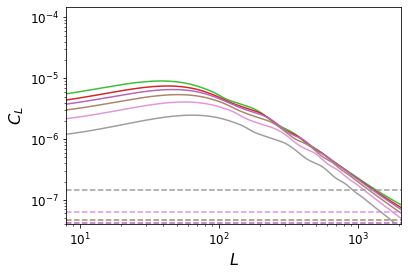

In [20]:
pl.plot_1dstyle(xlog=True,ylog=True,xmin=8,xmax=lmax,ymin=4e-8,ymax=1.5e-4)
for I, m0 in enumerate(camb_list):
    if m0 in ['P','W1']: continue
    plot(l,camb_cls[m0+m0][:lmax+1],color=cr[I],label=m0+m0)
    axhline(1./((40.*frac['lss'][I-2])*(10800./np.pi)**2),color=cr[I],ls='--')